# **Downwelling irradiance model**

## Model implementation (no validation)

This notebook presents the implementation of a downwelling irrandiance model considering atmospheric parameters and clear sky conditions.

**Author:** [Bruno Rech](https://github.com/b-rech) | **Created on:** 31 May 2025

* * *

### Dependencies

Read the documentation at the repository for further details.

**Important:** you need to authenticate and generate a token in your first access to Google Earth Engine. A Google Cloud project is required for this purpose. The token is valid for 7 days.

In [3]:
# Import libraries
import geemap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pvlib import spectrum, solarposition, irradiance, atmosphere

# Import auxiliary functions from another notebook
# Make sure that it is in the same folder as this one
%run auxiliary_functions.ipynb

### Date and periods

We need to provide information about the day and the period of interest:

In [49]:
# Inform the time zone of interest
tz = 'America/Sao_Paulo'

# Provide a date (yyyy-mm-dd)
date = '2023-12-21'

# Inform the time to start the model
# Must be an integer (e.g., '09:00')
time_start = '09:00'

# Provide the unity of the frequency
# (e.g., 'h' for hour, '15min' ...)
freq = '15min'

# Choose a number of periods to calculate
periods = 16

Based on the information provided, a list of datetimes is generated:

In [50]:
times = pd.date_range(f'{date} {time_start}',
                      freq=freq,
                      periods=periods,
                      tz=tz)

### Atmospheric parameters

The required atmospheric parameters are retrieved from datasets available in Google Earth Engine.

Please draw a rectangle below indicating the region of interest (ROI):

In [11]:
# Create map
Map = geemap.Map(zoom=3)

# Draw region of interest
Map.draw_features
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Let's extract the information from the ROI polygon:

In [12]:
# Get region of interest
roi = ee.FeatureCollection(Map.draw_features)

# Get centroid
centroid = (roi
            .first()
            .geometry()
            .centroid(maxError=1)
            .getInfo()['coordinates'])

# Get latitude and longitude separately
lat, lon = centroid[1], centroid[0]

print(f'Centroid at latitude {lat:.4f} and longitude {lon:.4f}')

Centroid at latitude -23.8395 and longitude -45.4342


Now we can retrieve the parameters.

**Important:** the aerosol optical depth (AOD) product from MODIS has gaps. Therefore, the algorithm was designed to expand the time window when data are not available. You can check the selected time window in the output below. Furthermore, atmospheric pressure can only be calculated in continental regions where the digital elevation model is available; otherwise, a default value at sea level is used (and indicated).

In [13]:
# Get parameters
aod_550, ozone, water, pressure = atmParams(date, roi)

Mean AOD: 0.273 (time window: 1)
Mean ozone column: 0.274 atm-cm
Water in the atmosphere: 3.00 cm
Atmospheric pressure: 92503 Pa (calculated)


### Model implementation

We need to provide aditional data related to surface positioning. Modify if necessary.

In [51]:
# Surface inclination (water = 0)
tilt = 0

# Azimuth (North=0)
# As inclination is zero, azimuth should not
# make any difference
azimuth = 0

# Surface albedo (water is low)
albedo = 0.05

# Solar position considering time and location
solpos = solarposition.get_solarposition(times, lat, lon)

# Area of interest
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

# Relative airmass at sea level
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith)

Finally, we can get the irradiance spectra:

In [52]:
model_spec = spectrum.spectrl2(apparent_zenith=solpos.apparent_zenith,
                               aoi=aoi,
                               surface_tilt=tilt,
                               ground_albedo=albedo,
                               surface_pressure=pressure,
                               relative_airmass=relative_airmass,
                               precipitable_water=water,
                               ozone=ozone,
                               aerosol_turbidity_500nm=aod_550)

Let's create an irradiance (global = direct + diffuse) dataframe:

In [53]:
# Get a dataframe
esm = pd.DataFrame(model_spec['poa_global'])

# Colnames are the times
esm.columns = [t.strftime('%H:%M') for t in times]

# Set wavelengths
esm['wl'] = model_spec['wavelength']

esm.head()

,09:00,09:15,09:30,09:45,10:00,10:15,10:30,10:45,11:00,11:15,11:30,11:45,12:00,12:15,12:30,12:45,wl
0,0.004842,0.006153,0.007564,0.009034,0.010516,0.011964,0.013330,0.014570,0.015644,0.016516,0.017158,0.017550,0.017679,0.017541,0.017140,0.016489,300.0
1,0.034056,0.039669,0.045291,0.050800,0.056078,0.061012,0.065502,0.069457,0.072800,0.075464,0.077400,0.078570,0.078953,0.078542,0.077344,0.075382,305.0
2,0.083586,0.094019,0.104200,0.113956,0.123126,0.131565,0.139141,0.145741,0.151269,0.155645,0.158807,0.160713,0.161335,0.160667,0.158716,0.155509,310.0
3,0.156357,0.171969,0.186978,0.201177,0.214378,0.226412,0.237133,0.246412,0.254143,0.260238,0.264629,0.267270,0.268131,0.267206,0.264503,0.260050,315.0
4,0.202985,0.221232,0.238668,0.255076,0.270261,0.284052,0.296296,0.306865,0.315651,0.322566,0.327542,0.330531,0.331506,0.330460,0.327399,0.322353,320.0


Lastly, let's plot the spectra:

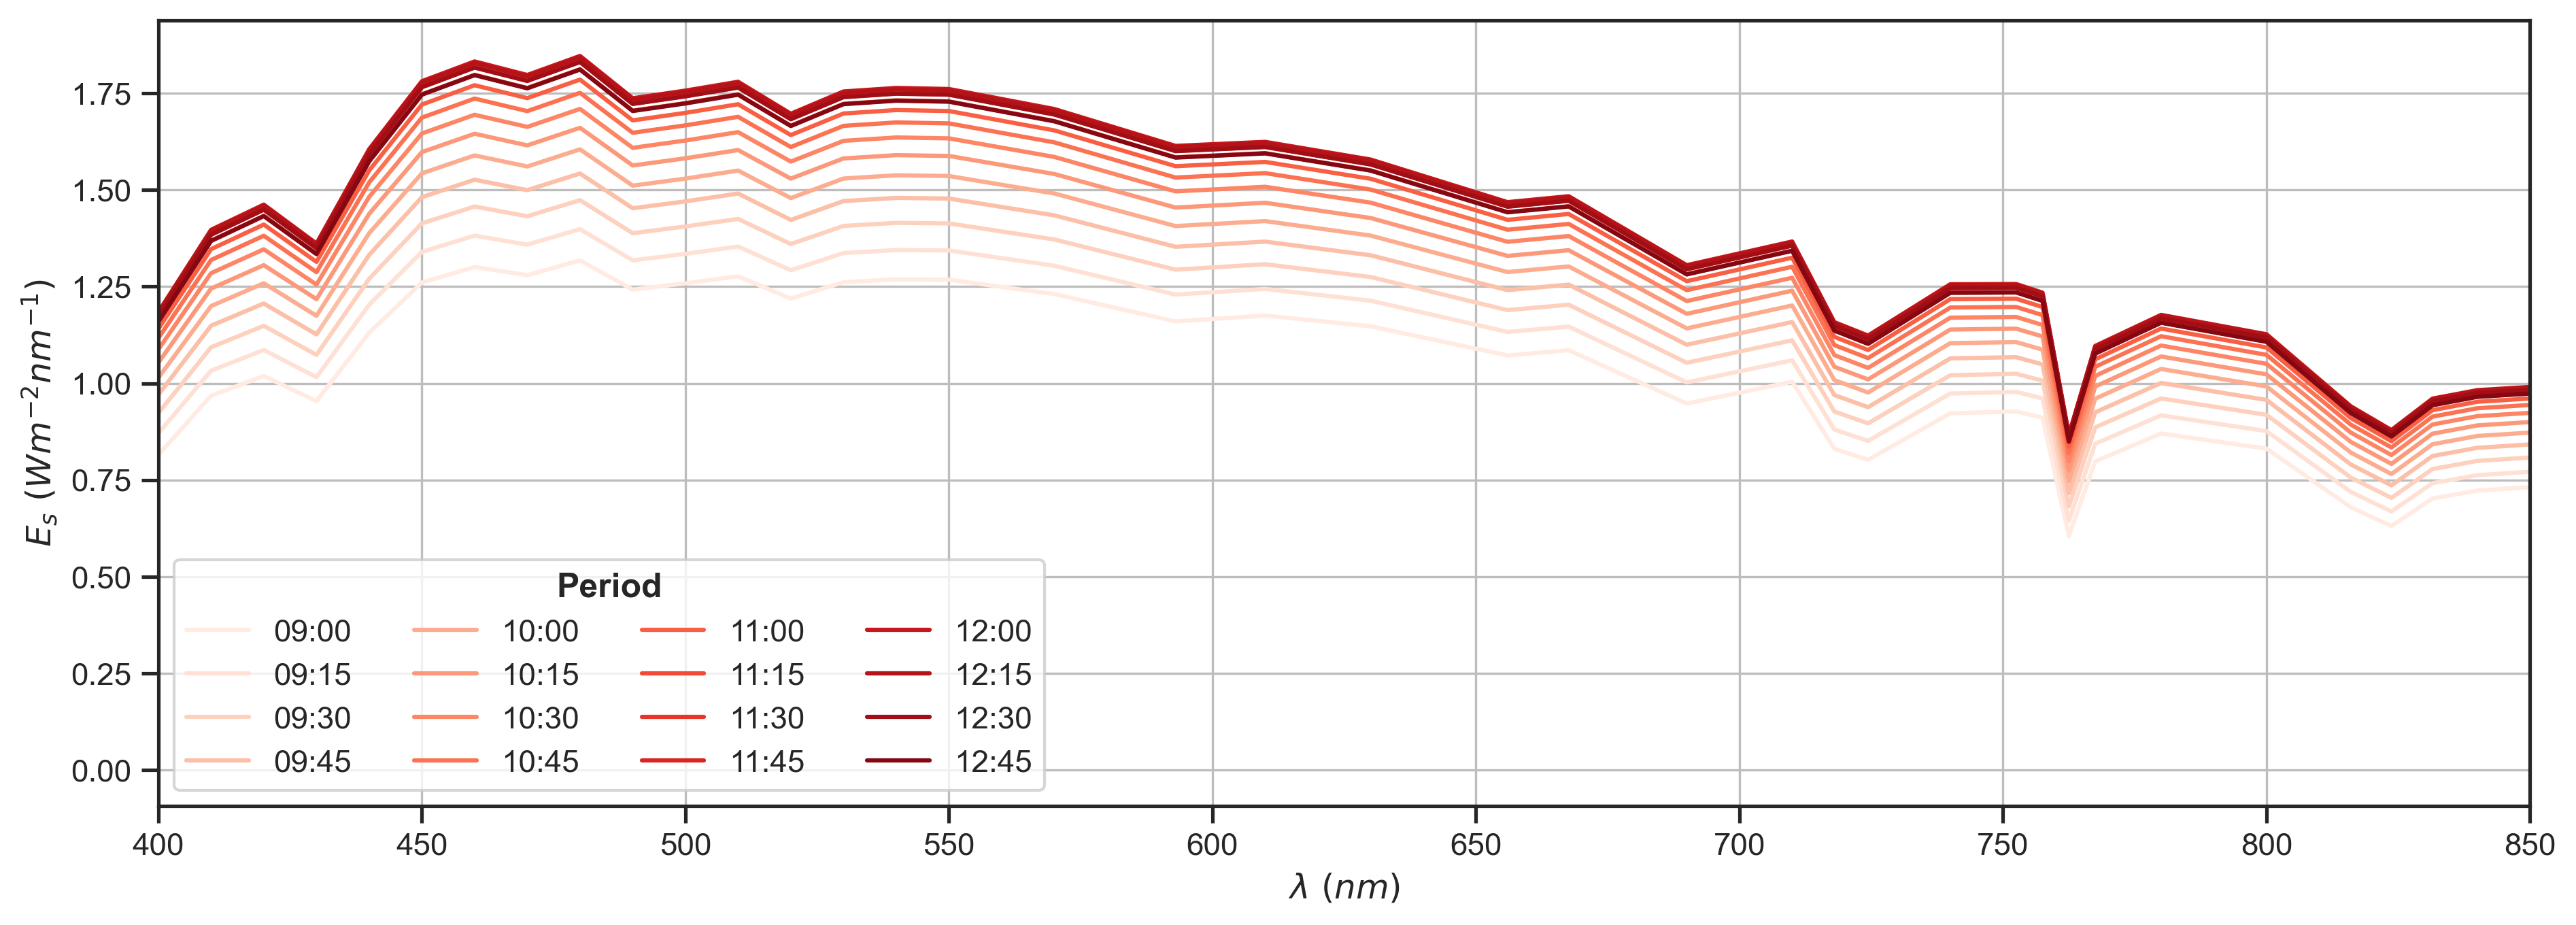

In [61]:
# Dataframes para formato longo
esm_long = esm.melt(id_vars='wl',
                    var_name='time',
                    value_name='es')

# Set plot theme
sns.set_theme(context='notebook',
              style='ticks')

# Create figure
ax, fig = plt.subplots(1, 1, dpi=300,
                      figsize=(15, 5))

# Create plot
sns.lineplot(data=esm_long, x='wl',
            y='es', hue='time', palette='Reds')

# Configure axes
plt.grid(which='major', color='#bdbdbd', linewidth=0.8)
plt.xlabel(r'$\lambda ~ (nm)$')
plt.ylabel(r'$E_s ~ (Wm^{-2}nm^{-1})$')
plt.xlim(400, 850)

# Configure legend
plt.legend(title='Period',
           title_fontproperties={'weight': 'bold'},
           ncol=4)

plt.show()